<a href="https://colab.research.google.com/github/kachytronico/Cursos-Colab-BDA/blob/main/Conversiones_precios_Pig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo**: El propósito de este ejemplo es convertir **con Apache Pig** este tipo de cadenas de texto a valores numéricos, eliminando previamente el símbolo $:

    $8.95 --> 8.95

En primer lugar, en este cuaderno de Colab tenemos un apartado con los scripts necesarios para instalar Hadoop y Pig.

Tras la instalación, hay un segundo apartado donde se desarrolla el ejemplo y el problema encontrado.

#**Apartado 1: Instalación de Hadoop y Pig**

In [ ]:
# Descargar Hadoop 3.3.6 desde el sitio oficial de Apache
!wget https://downloads.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz

# Descomprimir el archivo tar.gz descargado
!tar -xzf hadoop-3.3.6.tar.gz

# Mover la carpeta descomprimida a /usr/local/
!mv hadoop-3.3.6/ /usr/local/

# Establecer la variable de entorno JAVA_HOME para apuntar a la instalación de Java 11
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Agregar el directorio bin de Hadoop al PATH para que los comandos de Hadoop estén disponibles globalmente
os.environ["PATH"] = os.environ["PATH"] + ":" + "/usr/local/hadoop-3.3.6/bin"

# Verificar la versión de Hadoop instalada
!hadoop version

--2025-01-31 11:31:23--  https://downloads.apache.org/hadoop/common/hadoop-3.3.6/hadoop-3.3.6.tar.gz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 730107476 (696M) [application/x-gzip]
Saving to: ‘hadoop-3.3.6.tar.gz’

hadoop-3.3.6.tar.gz 100%[===================>] 696.28M  33.0MB/s    in 24s     

2025-01-31 11:31:47 (29.5 MB/s) - ‘hadoop-3.3.6.tar.gz’ saved [730107476/730107476]

Hadoop 3.3.6
Source code repository https://github.com/apache/hadoop.git -r 1be78238728da9266a4f88195058f08fd012bf9c
Compiled by ubuntu on 2023-06-18T08:22Z
Compiled on platform linux-x86_64
Compiled with protoc 3.7.1
From source with checksum 5652179ad55f76cb287d9c633bb53bbd
This command was run using /usr/local/hadoop-3.3.6/share/hadoop/common/hadoop-common-3.3.6.jar


In [ ]:
%%bash
wget https://downloads.apache.org/pig/pig-0.17.0/pig-0.17.0.tar.gz
tar -xzf pig-0.17.0.tar.gz
cp -r pig-0.17.0/ /usr/local/

--2025-01-31 11:37:15--  https://downloads.apache.org/pig/pig-0.17.0/pig-0.17.0.tar.gz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f8:10a:39da::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230606579 (220M) [application/x-gzip]
Saving to: ‘pig-0.17.0.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  242K 15m31s
    50K .......... .......... .......... .......... ..........  0%  481K 11m40s
   100K .......... .......... .......... .......... ..........  0% 1.27M 8m44s
   150K .......... .......... .......... .......... ..........  0%  774K 7m45s
   200K .......... .......... .......... .......... ..........  0% 11.2M 6m16s
   250K .......... .......... .......... .......... ..........  0% 78.6M 5m14s
   300K .......... .......... .......... .......... ..........  0% 1.39M 4m52s
   350K .......... ........

Establecemos las variables de entorno para Pig

In [ ]:
import os
os.environ["PIG_HOME"] = "/usr/local/pig-0.17.0"
os.environ["PATH"] = os.environ["PATH"] + ":" + "/usr/local/pig-0.17.0/bin"
os.environ["PIG_CLASSPATH"] = "/usr/local/hadoop-3.3.0/conf"

Verificamos la instalación

In [ ]:
!pig -h -version


Apache Pig version 0.17.0 (r1797386) 
compiled Jun 02 2017, 15:41:58

USAGE: Pig [options] [-] : Run interactively in grunt shell.
       Pig [options] -e[xecute] cmd [cmd ...] : Run cmd(s).
       Pig [options] [-f[ile]] file : Run cmds found in file.
  options include:
    -4, -log4jconf - Log4j configuration file, overrides log conf
    -b, -brief - Brief logging (no timestamps)
    -c, -check - Syntax check
    -d, -debug - Debug level, INFO is default
    -e, -execute - Commands to execute (within quotes)
    -f, -file - Path to the script to execute
    -g, -embedded - ScriptEngine classname or keyword for the ScriptEngine
    -h, -help - Display this message. You can specify topic to get help for that topic.
        properties is the only topic currently supported: -h properties.
    -i, -version - Display version information
    -l, -logfile - Path to client side log file; default is current working directory.
    -m, -param_file - Path to the parameter file
    -p, -param - K

# **Apartado 2: Convertir precios con símbolo $**

Parece ser que hay un problema en el manejo del símbolo $ en Pig.

Para ejemplificarlo, vamos a crear dos ficheros de texto, uno con las cantidades precedidas del símbolo $ (*precios.txt*) y otro con las cantidades precedidas del símbolo € (*precios_euros.txt*):

In [ ]:
# Crear un archivo de texto con datos de ejemplo con las cantidades expresadas en dólares
data = """$3.26
$10.50
$8.99
$5.00"""

with open('precios.txt', 'w') as f:
    f.write(data)

# Verificar el contenido del archivo creado
with open('precios.txt', 'r') as f:
    print(f.read())


$3.26
$10.50
$8.99
$5.00


In [ ]:
# Crear un archivo de texto con datos de ejemplo con las cantidades expresadas en euros
data = """€3.26
€10.50
€8.99
€5.00"""

with open('precios_euros.txt', 'w') as f:
    f.write(data)

# Verificar el contenido del archivo creado
with open('precios_euros.txt', 'r') as f:
    print(f.read())


€3.26
€10.50
€8.99
€5.00


Vamos a ver cómo sería la conversión del fichero *precios.txt* con **Pandas**:

In [ ]:
import pandas as pd

# Leer el archivo, forzando la columna 'precio' como tipo string
df = pd.read_csv('precios.txt', header=None, names=['precio'], dtype={'precio': str})

# Eliminar el símbolo del dólar y convertir a numérico
df['precio_limpio'] = df['precio'].str.replace('$', '').astype(float)

# Mostrar el DataFrame resultante
print(df)

print(df.dtypes)

   precio  precio_limpio
0   $3.26           3.26
1  $10.50          10.50
2   $8.99           8.99
3   $5.00           5.00
precio            object
precio_limpio    float64
dtype: object


Como podemos ver, el proceso concluye con éxito: se ha eliminado el símbolo $ y el campo ahora es numérico.

---



Ahora vamos a intentarlo con Apache Pig.

En primer lugar, escribimos el fichero que lee y muestra el contenido del archivo *precios.txt*:

In [ ]:
%%writefile leer_precios.pig
-- Cargar los datos desde el archivo
precios = LOAD 'precios.txt' USING PigStorage('\n') AS (precio:chararray);

-- Mostrar los datos cargados (esto nos ayuda a verificar si están bien cargados)
DUMP precios;

Writing leer_precios.pig


Lo ejecutamos:

In [ ]:
!pig leer_precios.pig

2025-01-31 11:38:16,532 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-31 11:38:16,533 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-31 11:38:16,533 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-31 11:38:16,622 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-31 11:38:16,622 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1738323496599.log
2025-01-31 11:38:17,178 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-31 11:38:17,270 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-31 11:38:17,270 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-31 11:38:17,343 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

Al final de la ejecución, vemos el contenido que ha leído:

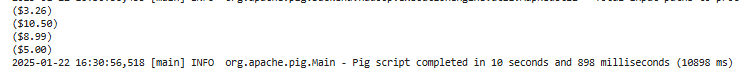

Ahora vamos a escribir un script de pig que cargue los datos del fichero *precios.txt* y elimine el símbolo $:

In [ ]:
%%writefile limpiar_precios_dolar.pig

-- Cargar los datos desde el archivo
precios = LOAD 'precios.txt' USING PigStorage('\n') AS (precio:chararray);

-- Limpiar los datos (eliminar el signo '$')
precios_limpios = FOREACH precios GENERATE REPLACE(precio, '\\$', '');

-- Mostrar los datos después de limpiar (esto es solo para verificar la limpieza)
DUMP precios_limpios;

Writing limpiar_precios_dolar.pig


Y lo ejecutamos:

La ejecución da el siguiente error:

    2025-01-22 17:39:09,101 [main] ERROR org.apache.pig.tools.grunt.Grunt - ERROR 1200: <file limpiar_precios_dolar.pig, line 6, column 61>  Unexpected character '$'\



# Esto puede ser por cómo Pig interpreta los caracteres especiales, en este caso $, dentro de las cadenas de caracteres. Si usamos REGEX_EXTRACT en lugar de REPLACE:

In [ ]:
%%writefile limpiar_precios_dolar2.pig

-- Cargar los datos desde el archivo
precios = LOAD 'precios.txt' USING PigStorage('\n') AS (precio:chararray);

-- Limpiar los datos (eliminar el signo '$') utilizando expresiones regulares
precios_limpios = FOREACH precios GENERATE REGEX_EXTRACT(precio, '([0-9.]+)', 1) AS precio_limpio:double;

-- Mostrar los datos después de limpiar (esto es solo para verificar la limpieza)
DUMP precios_limpios;

Overwriting limpiar_precios_dolar2.pig


In [ ]:
!pig limpiar_precios_dolar2.pig

2025-01-31 11:44:53,770 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-31 11:44:53,771 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-31 11:44:53,771 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-31 11:44:53,868 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-31 11:44:53,868 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1738323893852.log
2025-01-31 11:44:54,344 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-31 11:44:54,459 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-31 11:44:54,459 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-31 11:44:54,508 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

Como comentábamos anteriormente, parece que se trata de un error específico con ese símbolo $.

Aunque no sea muy coherente, vamos a probar el mismo script pero que, en lugar de suprimir el símbolo $, elimine los ceros que se encuentre:

In [ ]:
%%writefile limpiar_precios_ceros.pig
-- Cargar los datos desde el archivo
precios = LOAD 'precios.txt' USING PigStorage('\n') AS (precio:chararray);

-- Limpiar los datos (eliminar el cero)
precios_limpios = FOREACH precios GENERATE REPLACE(precio, '0', '');

-- Mostrar los datos después de limpiar (esto es solo para verificar la limpieza)
DUMP precios_limpios;

Overwriting limpiar_precios_ceros.pig


Lo ejecutamos:

In [ ]:
!pig limpiar_precios_ceros.pig

2025-01-22 18:02:23,717 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-22 18:02:23,720 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-22 18:02:23,720 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-22 18:02:23,840 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-22 18:02:23,840 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1737568943818.log
2025-01-22 18:02:24,362 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-22 18:02:24,475 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-22 18:02:24,476 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-22 18:02:24,519 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

Ahora vemos que ya no aparecen ceros en las cantidades procesadas:

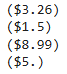



Vamos a hacer otra prueba, pero ahora utilizando el fichero *precios_euros.txt* para eliminar el símbolo €.

En primer lugar, lo leemos con Apache Pig. En este caso, además, añadimos una línea para mostrar el tipo de dato leído:

In [ ]:
%%writefile leer_precios_euros.pig
-- Cargar los datos desde el archivo
precios = LOAD 'precios_euros.txt' USING PigStorage('\n') AS (precio:chararray);

-- Mostrar los datos cargados (esto nos ayuda a verificar si están bien cargados)
DUMP precios;

-- Mostrar la estructura y los tipos de los datos
DESCRIBE precios;

Overwriting leer_precios_euros.pig


Y lo ejecutamos:

In [ ]:
!pig leer_precios_euros.pig

2025-01-22 18:03:09,132 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-22 18:03:09,134 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-22 18:03:09,134 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-22 18:03:09,224 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-22 18:03:09,224 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1737568989204.log
2025-01-22 18:03:09,796 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-22 18:03:09,935 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-22 18:03:09,935 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-22 18:03:09,990 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

La lectura se realiza correctamente:

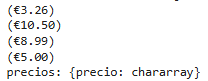

Ahora escribimos el script para eliminar el símbolo del euro:

In [ ]:
%%writefile limpiar_precios_euros.pig

-- Cargar los datos desde el archivo
precios = LOAD 'precios_euros.txt' USING PigStorage('\n') AS (precio:chararray);

-- Limpiar los datos (eliminar el signo '€')
precios_limpios = FOREACH precios GENERATE REPLACE(precio, '\\€', '');

-- Mostrar los datos después de limpiar (esto es solo para verificar la limpieza)
DUMP precios_limpios;

-- Mostrar la estructura y los tipos de los datos
DESCRIBE precios_limpios;

Overwriting limpiar_precios_euros.pig


In [ ]:
!pig limpiar_precios_euros.pig

2025-01-22 18:03:36,021 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-22 18:03:36,028 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-22 18:03:36,029 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-22 18:03:36,141 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-22 18:03:36,141 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1737569016121.log
2025-01-22 18:03:36,742 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-22 18:03:36,855 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-22 18:03:36,855 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-22 18:03:36,902 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

Vemos que se ejecuta correctamente:

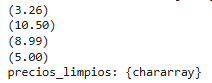

Eso sí, como no hemos indicado nada al respecto, los datos siguen siendo cadenas de texto (chararray).

Como el script anterior ha funcionado, ahora podemos ir un paso más allá y modificar el script para no sólo reemplazar el símbolo €, sino también realizar la conversión del tipo de dato:

In [ ]:
%%writefile limpiar_y_convertir_precios_euros.pig

-- Cargar los datos desde el archivo
precios = LOAD 'precios_euros.txt' USING PigStorage('\n') AS (precio:chararray);

-- Limpiar los datos (eliminar el signo '€') y convertir a número
precios_limpios = FOREACH precios GENERATE
    (double) REPLACE(precio, '\\€', '');

-- Mostrar los datos después de limpiar y convertir (esto es solo para verificar la limpieza)
DUMP precios_limpios;

-- Mostrar la estructura y los tipos de los datos
DESCRIBE precios_limpios;

Overwriting limpiar_y_convertir_precios_euros.pig


In [ ]:
!pig limpiar_y_convertir_precios_euros.pig

2025-01-22 18:04:03,963 INFO pig.ExecTypeProvider: Trying ExecType : LOCAL
2025-01-22 18:04:03,969 INFO pig.ExecTypeProvider: Trying ExecType : MAPREDUCE
2025-01-22 18:04:03,969 INFO pig.ExecTypeProvider: Picked MAPREDUCE as the ExecType
2025-01-22 18:04:04,063 [main] INFO  org.apache.pig.Main - Apache Pig version 0.17.0 (r1797386) compiled Jun 02 2017, 15:41:58
2025-01-22 18:04:04,064 [main] INFO  org.apache.pig.Main - Logging error messages to: /content/pig_1737569044045.log
2025-01-22 18:04:04,638 [main] INFO  org.apache.pig.impl.util.Utils - Default bootup file /root/.pigbootup not found
2025-01-22 18:04:04,748 [main] INFO  org.apache.hadoop.conf.Configuration.deprecation - mapred.job.tracker is deprecated. Instead, use mapreduce.jobtracker.address
2025-01-22 18:04:04,749 [main] INFO  org.apache.pig.backend.hadoop.executionengine.HExecutionEngine - Connecting to hadoop file system at: file:///
2025-01-22 18:04:04,800 [main] INFO  org.apache.pig.PigServer - Pig Script ID for the ses

Finalmente, obtenemos las cantidades sin el símbolo € y en tipo de datos numérico:

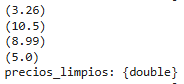